## How far away we are from the next credit crisis? 
#### Exploring a decade-long single-family loan from Fannie Mae

It’s been more than 10 years since the 2008 American Subprime Mortgage crisis during which millions of Americans lost their homes, their jobs, or both. Following the collapse of Lehman Brothers, the S&P 500 fell by 28 percent in the 22 trading days. The unemployment rate jumped from 6.1 percent in August 2008 to 9.5 percent two years later in August 2010. 

Many more regulations have been put in place to increase oversight with the hope of preventing or at least lowering the possibility of next alike credit crisis. For instance, the Dodd-Frank financial reform created entities such as the Consumer Financial Protection Bureau (CFPB) and put in place new regulations and tools for banking supervision and oversight by entities such as FDIC.

However, financial crises are sometimes inevitable.

***“Regardless of improvements in law and regulation, every financial system is vulnerable to a possible crisis. Throughout history, financial crises have emerged from many types of assets, from Dutch tulips to US subprime mortgages.”*** ---Aaron Klein, a fellow at the Brookings Institution

While there are many articles and experts discussing the coming of the next financial crisis, like [this one](https://www.vox.com/2018/9/18/17868074/financial-crisis-dodd-frank-lehman-brothers-recession) which provide us a lot of insights into the core of the financial crisis, in this project, I would like to take a data analysis approach to this topic. In the following I will introduce the data, followed by data cleaning, some exploratory data analysis and proposal for deeper investigation.

## Data:

Fannie Single family loan data, which is avaliable [here](https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html). The data records loans that are acquired by Fannie Mae from 2000 to 2018 at a quarterly basis. It contains both static infomation of loans and their later performance like forceclosure status. The originial files don't include headers. You can find headers info [here](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf). If you are not familiar with the terminology, you may find the glossory very helpful, [glossory](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf)

After unziped, the data is 190.35 GB. The size of the data imposes computational challenge for analysis but I have addressed it with some ad hoc method which I will discuss later.  

## Data Cleanning!

As always, in dealing with real world data, the first step is to clean up the data. While the single family loan data published by Fannie Mae is relatively clean reading and combining all the files together are time-consuming. Ideally, I would like to read in all the acquisition file then combine them into a single file and do the same thing to performance data. However, the data (especially the performance data) is so huge that this is simply not doable on my computer. So I clean and combine them piece by piece. Below are the code for reading cand cleanning the data:

In [1]:
# import necessary libs
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as mp
import datetime as dt
%matplotlib inline
from matplotlib import pyplot as plt
low_memory=False

In [2]:
DATA_DIR = '/Volumes/Backup Plus/Documents/Data Science/Projects/fannieMae_project/raw_data'
PROCESSED_DIR ='/Volumes/Backup Plus/Documents/Data Science/Projects/fannieMae_project/processed_data'
MINIMUM_TRACKING_QUARTERS = 4
TARGET = "foreclosure_status"
NON_PREDICTORS = [TARGET, "LoanID"]
CV_FOLDS = 3

In [3]:
Acquisition=[
           'LoanID',
           'Channel',
           'SellerName',
           'OrInterestRate',
           'OrUnpaidPrinc',
           'OrLoanTerm',
           'Origination',
           'FirstPayment',
           'OrLTV',
           'OrCLTV',
           'NumBorrowers',
           'DTIRat',
           'CreditScore',
           'FTHomeBuyer',
           'LoanPurpose',
           'PropertyType',
           'NumUnits',
           'OccType',
           'PropertyState',
           'Zip',
           'MortInsPerc',
           'ProductType',
           'CoCreditScore',
           'MortInsType',
           'RelocationMortgage'],
Performance=[
           'LoanID',
           'ReportPeriod',
           'Servicer',
           'CurrInterestRate',
           'CAUPB','LoanAge',
           'MonthsToMaturity',
           'AdMonthsToMaturity',
           'MaturityDate',
           'MSA',
           'CLDS',
           'ModFlag',
           'ZeroBalCode',
           'ZeroBalDate',
           'LastInstallDate',
           'ForeclosureDate',
           'DispositionDate', 
           'ForceclosureCost', 
           'PPRC',
           'AssetRecCost',
           'MHRC',
           'Tax',
           'NetSaleProceeds',
           'CreditEnhProceeds',
           'RPMWP',
           'OtherForceCloProcd',
           'NnonIntr_UPB',
           'PrinForgAmount',
           'RMWPFlag',
           'ForceWriteOffAmount',
           'ServicingIndicator']

In [4]:

Performance_Select=[
        "LoanID",
        "MSA",
        "ForeclosureDate"
    ]

In [5]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [6]:
def concatenate_1(prefix="Acquisition"):
    files = os.listdir(DATA_DIR)
    full = []
    for f in files:
        if not f.startswith(prefix):
            continue
        data = pd.read_csv(os.path.join(DATA_DIR, f), sep="|", header=None, names=Acquisition, index_col=False)
        data = data[Acquisition]
        data = data.dropna()
        full.append(data)

    full = pd.concat(full, axis=0)

    full.to_csv(os.path.join(PROCESSED_DIR, "{}.txt".format(prefix)), sep="|", header=Acquisition, index=False)

In [7]:
def concatenate_2(prefix="Performance"):
    files = os.listdir(DATA_DIR)
    full = []
    for f in files:
        if not f.startswith(prefix):
            continue
        data = pd.read_csv(os.path.join(DATA_DIR, f), sep="|", header=None, names=Performance, 
            dtype={'LoanID':'int64',
'ReportPeriod':'object',
'Servicer':'object',
'CurrInterestRate':'float64',
'CAUPB':'float64',
'LoanAge':'int64',
'MonthsToMaturity':'float64',
'AdMonthsToMaturity':'float64',
'MaturityDate':'object',
'MSA':'int64',
'CLDS':'object',
'ModFlag':'object',
'ZeroBalCode':'float64',
'ZeroBalDate':'object',
'LastInstallDate':'object',
'ForeclosureDate':'object',
'DispositionDate':'object',
'ForceclosureCost':'float64',
'PPRC':'float64',
'AssetRecCost':'float64',
'MHRC':'float64',
'Tax':'float64',
'NetSaleProceeds':'float64',
'CreditEnhProceeds':'float64',
'RPMWP':'float64',
'OtherForceCloProcd':'float64',
'NnonIntr_UPB':'float64',
'PrinForgAmount':'float64',
'RMWPFlag':'object',
'ForceWriteOffAmount':'float64',
'ServicingIndicator':'object'}
                           ,index_col=False)
        data = data[[
        "LoanID",
        "MSA",
        "ForeclosureDate"
    ]]
        data = data.dropna(subset=['MSA', 'ForeclosureDate'])
        full.append(data)

    full = pd.concat(full, axis=0)

    full.to_csv(os.path.join(PROCESSED_DIR, "{}.txt".format(prefix)), sep="|", header=[
        "LoanID",
        "MSA",
        "ForeclosureDate"
    ], index=False)

In [11]:
if __name__ == "__main__":
    concatenate_1("Acquisition_2000")
    concatenate_1("Acquisition_2001")
    concatenate_1("Acquisition_2002")
    concatenate_1("Acquisition_2003")
    concatenate_1("Acquisition_2004")
    concatenate_1("Acquisition_2005")
    concatenate_1("Acquisition_2006")
    concatenate_1("Acquisition_2007")
    concatenate_1("Acquisition_2008")
    concatenate_1("Acquisition_2009")
    concatenate_1("Acquisition_2010")
    concatenate_1("Acquisition_2011")
    concatenate_1("Acquisition_2012")
    concatenate_1("Acquisition_2013")
    concatenate_1("Acquisition_2014")
    concatenate_1("Acquisition_2015")
    concatenate_1("Acquisition_2016")
    concatenate_1("Acquisition_2017")
    concatenate_1("Acquisition_2018")

In [9]:
if __name__ == "__main__":
    concatenate_2("Performance_2000")
    concatenate_2("Performance_2001")
    concatenate_2("Performance_2002")
    concatenate_2("Performance_2003")
    concatenate_2("Performance_2004")
    concatenate_2("Performance_2005")
    concatenate_2("Performance_2006") 
    concatenate_2("Performance_2007")  
    concatenate_2("Performance_2008")
    concatenate_2("Performance_2009")
    concatenate_2("Performance_2010")
    concatenate_2("Performance_2011")
    concatenate_2("Performance_2012")
    concatenate_2("Performance_2013")
    concatenate_2("Performance_2014") 
    concatenate_2("Performance_2015") 
    concatenate_2("Performance_2016") 
    concatenate_2("Performance_2017")  
    concatenate_2("Performance_2018")

In [40]:
def concatenate_3(prefix="Performance"):
    files = os.listdir(PROCESSED_DIR)
    full = []
    for f in files:
        if not f.startswith(prefix):
            continue
        data = pd.read_csv(os.path.join(PROCESSED_DIR, f), sep="|",index_col=False)
        full.append(data)
    full = pd.concat(full, axis=0)

    full.to_csv(os.path.join(PROCESSED_DIR, "{}.txt".format(prefix)), sep="|", index=False)

In [41]:
concatenate_3("Performance")

In [42]:
concatenate_3("Acquisition")

In [8]:
acqusition = pd.read_csv('/Volumes/Backup Plus/Documents/Data Science/Projects/fannieMae_project/processed_data/Acquisition.txt', sep="|",index_col=False)

In [9]:
performance = pd.read_csv('/Volumes/Backup Plus/Documents/Data Science/Projects/fannieMae_project/processed_data/Performance.txt', sep="|",index_col=False)

In [10]:
df=pd.merge(acqusition, performance, on='LoanID', how='left')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3194421 entries, 0 to 3194420
Data columns (total 28 columns):
LoanID                int64
Channel               object
SellerName            object
OrInterestRate        float64
OrUnpaidPrinc         int64
OrLoanTerm            int64
loan_date             datetime64[ns]
first_payment_date    datetime64[ns]
OrLTV                 float64
OrCLTV                float64
NumBorrowers          float64
DTIRat                float64
CreditScore           float64
FTHomeBuyer           object
LoanPurpose           object
PropertyType          object
NumUnits              int64
OccType               object
PropertyState         object
Zip                   int64
MortInsPerc           float64
ProductType           object
CoCreditScore         float64
MortInsType           float64
RelocationMortgage    object
MSA                   float64
ForeclosureDate       datetime64[ns]
Default               int64
dtypes: datetime64[ns](3), float64(10), int64(6

In [11]:
df['Default']=df['ForeclosureDate']
df['Default'].fillna(0, inplace=True)
df.loc[df['Default'] != 0, 'Default'] = 1
df['Default'] = df['Default'].astype(int)

In [12]:
df.rename(columns={'Origination':'loan_date',
                          'FirstPayment':'first_payment_date'}, 
                 inplace=True)

In [14]:
df[['loan_date', 'first_payment_date', 'ForeclosureDate']]=df[['loan_date', 'first_payment_date', 'ForeclosureDate']].apply(lookup)

In [65]:
df['PropertyState'].nunique()
df['PropertyState'].unique()

array(['CA', 'RI', 'AR', 'MI', 'WI', 'MO', 'KS', 'AZ', 'OH', 'NC', 'IL',
       'PA', 'CO', 'MN', 'LA', 'FL', 'ID', 'TX', 'NV', 'OK', 'WA', 'NM',
       'NJ', 'VA', 'NY', 'IN', 'IA', 'AK', 'UT', 'MD', 'TN', 'CT', 'WV',
       'GA', 'MS', 'SC', 'ME', 'NE', 'OR', 'KY', 'NH', 'MA', 'AL', 'WY',
       'VT', 'MT', 'SD', 'HI', 'PR', 'DE', 'DC', 'ND', 'GU', 'VI'],
      dtype=object)

In [35]:
df['first_payment_year']=df['first_payment_date'].dt.year

In [43]:
df['first_payment_month']=df['first_payment_date'].dt.month

In [55]:
os.getcwd()

'/Users/yd/Documents/Data Science/Projects/fannieMae_project'

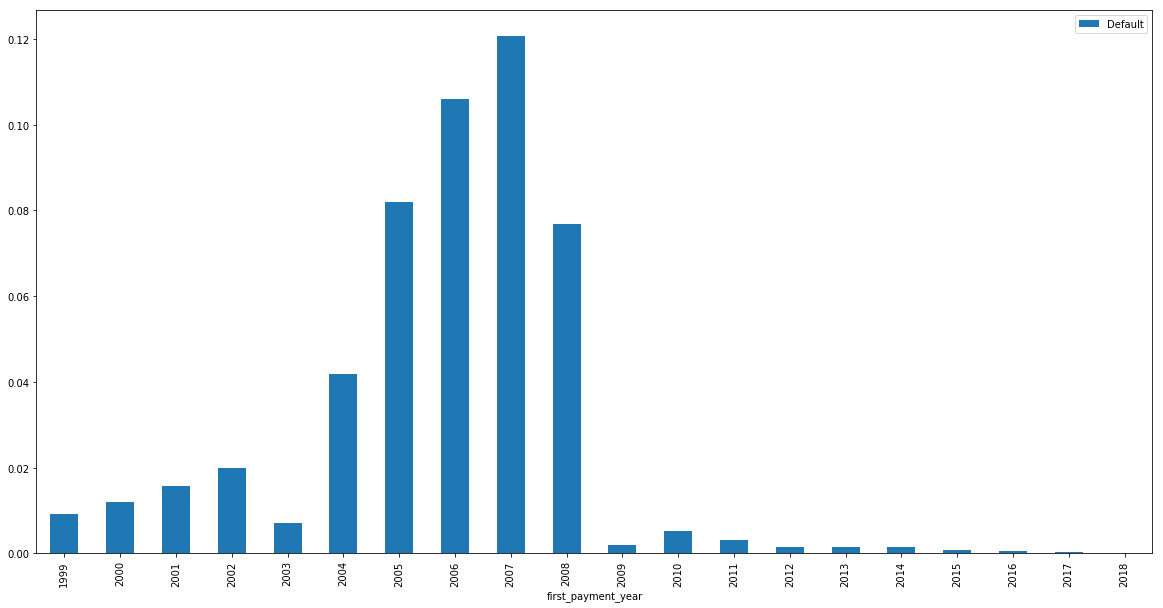

In [59]:
## default over time of loan origination
plt.rcParams["figure.figsize"] = (20,10)
df.groupby(['first_payment_year']).agg({'Default':'mean'}).plot(kind='bar')
plt.savefig('default_over_time.png')

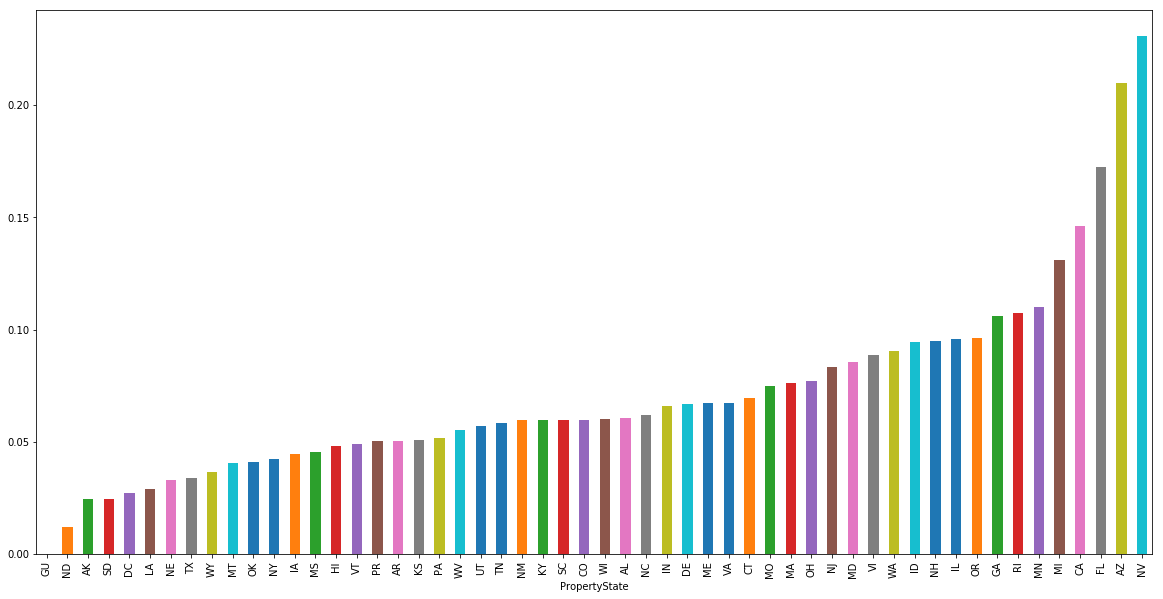

In [60]:
plt.rcParams["figure.figsize"] = (20,10)
df.loc[(df['first_payment_date'].dt.year >=2004) & (df['first_payment_date'].dt.year <=2008)].groupby('PropertyState')['Default'].mean().sort_values().plot(kind='bar')
plt.savefig('default_by_state.png')

In [ ]:
groupby('PropertyState')['Default'].mean().sort_values().plot(kind='bar')


Observation1:
    The figure above shows the loan default rate by states. Notice there are two  

In [ ]:
loans_state=df.groupby('PropertyState').agg({"LoanID": "count",
                                              "OrInterestRate":"mean",
                                              "OrUnpaidPrinc":"median",
                                              "OrLoanTerm":"mean",
                                              "OrLTV":"mean",
                                              "OrCLTV":"mean",
                                              "NumBorrowers":"mean",
                                              "DTIRat":"mean",
                                              "CreditScore":"mean",
                                              "NumUnits":"mean",
                                              "MortInsPerc":"mean",
                                              "CoCreditScore":"mean"})

In [ ]:
loans_yearly=df.groupby('PropertyState').agg({"LoanID": "count",
                                              "OrInterestRate":"mean",
                                              "OrUnpaidPrinc":"median",
                                              "OrLoanTerm":"mean",
                                              "OrLTV":"mean",
                                              "OrCLTV":"mean",
                                              "NumBorrowers":"mean",
                                              "DTIRat":"mean",
                                              "CreditScore":"mean",
                                              "NumUnits":"mean",
                                              "MortInsPerc":"mean",
                                              "CoCreditScore":"mean"})

In [91]:
quarterly_loans

,LoanID,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrLTV,OrCLTV,NumBorrowers,DTIRat,CreditScore,NumUnits,MortInsPerc,CoCreditScore
PropertyState,,,,,,,,,,,,
AK,1416,5.753923,249000,346.205508,90.204096,90.225282,2.004944,38.056497,728.538842,1.041667,22.089689,729.932203
AL,8645,6.075559,167000,338.926778,90.234471,90.265818,2.004280,36.277386,725.990052,1.002082,21.868942,729.006362
AR,4849,6.079937,144000,334.196742,90.162920,90.184162,2.005568,36.622603,727.951536,1.008455,21.203341,730.211178
AZ,8281,6.148213,216000,353.085135,90.181621,90.203961,2.015699,39.023306,732.001691,1.001328,22.256491,733.276054
CA,18157,5.957217,314000,357.021865,89.862367,89.885333,2.025720,40.236713,743.069229,1.006774,21.510272,744.920582
CO,8631,5.938396,234000,352.862009,90.293940,90.341444,2.009269,37.743135,741.944502,1.004287,22.179469,743.284556
CT,3396,6.082143,255000,350.633098,90.045347,90.090695,2.004417,39.380448,726.495289,1.031508,21.827739,728.197291
DC,306,6.016422,351500,356.862745,89.980392,90.039216,2.019608,34.993464,739.267974,1.009804,22.179739,742.565359
DE,1334,6.117344,254500,349.101199,89.841079,89.852324,2.015742,38.922039,725.477511,1.009745,21.757871,726.703898


In [67]:
defaults=pd.read_csv(os.path.join(PROCESSED_DIR, "Performance.txt"), sep="|", header=0, index_col=["ForeclosureDate"], parse_dates=True)

In [68]:
# defaults_new['ForeclosureDate']=lookup(defaults_new['ForeclosureDate'])

In [92]:
quarterly_defaults=defaults.groupby('MSA').agg({"LoanID": 'count'})

In [93]:
quarterly_defaults

,LoanID
MSA,
0,7596
10180,7
10380,18
10420,161
10500,23
10540,37
10580,98
10740,240
10780,18


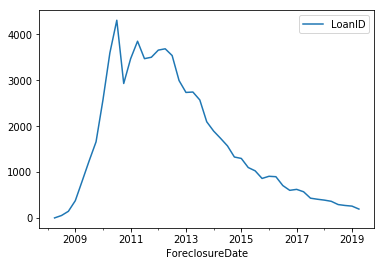

In [89]:
quarterly_defaults.plot()